In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 20:38:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run if using Google Colab

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary packages
!pip install datasets
!pip install transformers

In [4]:
# Load datasets from files
from datasets import load_dataset

# Create Datast object from dataframe
from datasets import Dataset

# For training
import tensorflow as tf

# To load pretrained model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Collate data for training with batches
from transformers import DataCollatorWithPadding

# Drive path - Change this to your Drive path with the datasets.
path = '/content/drive/MyDrive/Proyectos/NLP ResMex/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_theme()

In [5]:
# Check GPU availability
import torch

torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [6]:
def eval_model(model, validation_dataset, dataset, path = 'no'):
    """Model evaluation

    Prints MAE, accuracy and confusion matrix for the given model and dataset.
    Args:
        model (tf.keras.Model): Model to evaluate
        validation_dataset (tf.data.Dataset): Dataset to evaluate on
        dataset (Dataset): Dataset to evaluate

    Returns:
        None
    """
    preds = model.predict(validation_dataset)["logits"]
    preds = np.argmax(preds, axis=1)
    true = list(dataset['label'])

    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true, preds)
    print(f'MAE: {mae.result().numpy()}')

    acc = tf.keras.metrics.Accuracy()
    acc.update_state(true, preds)
    print(f'Accuracy: {acc.result().numpy()}')

    cm = confusion_matrix(true, preds)

    df = pd.DataFrame(cm)

    sns.set(font_scale=1.4)
    sns.heatmap(df, annot=True, annot_kws={"size": 16},
                cmap="Greens", fmt='.1f',
                cbar_kws={'label': 'count'}, cbar = False)

    # Colorbar
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    if path != 'no':
        plt.savefig(path + 'matrix.png')
        with open(path + 'test.txt', 'w') as f:
            f.write(f'Accuracy: {acc.result().numpy()}')
            f.write(f'MAE: {mae.result().numpy()}')
    plt.show()

In [7]:
data_eval = pd.read_csv(path + 'Evaluation/anotaciones_test.csv')

data_eval.head(3)

,Id,Polaridad,TipoAtraccion,Title,Opinion
0,7387,2.666667,Hotel,"Hermosos jardines, unos pocos problemas pero e...",Tuvimos un tiempo estupendo en México. La prop...
1,11007,4.000000,Hotel,Otro increíble 'rockin' de Navidad!!!,Si abrazar este hotel está a unos le encanta. ...
2,2044,4.000000,Hotel,Increíble personal. te hacen sentir como de la...,Nos alojamos en El Samba del 23 de enero al 6 ...


In [8]:
# Polarity to nearest integer
data_eval['Polaridad'] = data_eval['Polaridad'].round(0).astype(int)

# Merge Title and Opinion columns
for index in data_eval.index:
    data_eval.at[index, 'Opinion'] = str(data_eval.at[index, 'Opinion']) \
        + '. ' + str(data_eval.at[index, 'Title'])

# Rename labels (Keras stars label count at 0)
data_eval['label'] = data_eval['Polaridad'].replace({1:0, 2:1, 3:2, 4:3, 5:4})

# Drop Title and Attraction columns
data_eval = data_eval.drop(columns=['Title', 'Polaridad'])

data_eval.head()

,Id,TipoAtraccion,Opinion,label
0,7387,Hotel,Tuvimos un tiempo estupendo en México. La prop...,2
1,11007,Hotel,Si abrazar este hotel está a unos le encanta. ...,3
2,2044,Hotel,Nos alojamos en El Samba del 23 de enero al 6 ...,3
3,11587,Hotel,2008 fue nuestra primera vez y nos Grand Velas...,4
4,5679,Hotel,la peor experiencia durante nuestra visita a e...,0


In [12]:
# Pre-train checkpoint model from 🤗 (MIT License)
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'

# Load model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data collator for batch processing
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Batch size
batch_size = 8

# Convert dataframe to Dataset object
dataset = Dataset.from_pandas(data_eval, preserve_index=False)

dataset

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Dataset({
    features: ['Id', 'TipoAtraccion', 'Opinion', 'label'],
    num_rows: 200
})

In [16]:
# Tokenize entries
def tokenize_function(example):
    try:
        return tokenizer(example['Opinion'], truncation=True)
    except:
        print(example['Opinion'])

# Tokenize whole dataset
dataset = dataset.map(tokenize_function, batched=True)

dataset

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['Id', 'TipoAtraccion', 'Opinion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

In [17]:
# Test set
tf_test_dataset = dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

In [39]:
test_models = [path + 'models/model_FULL_total', # Train with full augmented dataset
               'nlptown/bert-base-multilingual-uncased-sentiment', # Original model
               path + 'models/model_original_train'] # Train with original train set

Some layers from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions w

MAE: 0.32499998807907104
Accuracy: 0.699999988079071


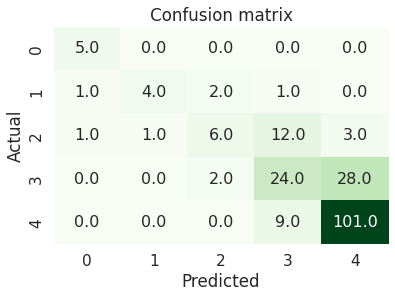

In [40]:
model = TFAutoModelForSequenceClassification.from_pretrained(test_models[0])

eval_model(model, tf_test_dataset, dataset)

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


MAE: 0.4000000059604645
Accuracy: 0.6700000166893005


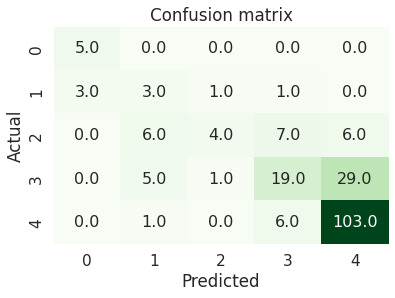

In [41]:
model = TFAutoModelForSequenceClassification.from_pretrained(test_models[1])

eval_model(model, tf_test_dataset, dataset)

Some layers from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_original_train were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_original_train.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predi

MAE: 0.3700000047683716
Accuracy: 0.6700000166893005


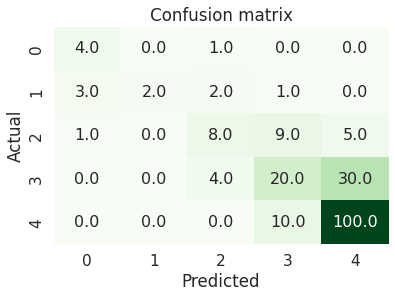

In [42]:
model = TFAutoModelForSequenceClassification.from_pretrained(test_models[2])

eval_model(model, tf_test_dataset, dataset)

# UMAP

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(test_models[0], 
                                                             output_hidden_states=True)

In [ ]:
# Test set
tf_test_dataset = dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=1,
)

In [ ]:
a = [model.predict(datapoint) for datapoint in tf_test_dataset]
preds = [np.argmax(preds_point['logits']) for preds_point in a]

In [ ]:
a[0].keys()

odict_keys(['logits', 'hidden_states'])

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
np.array(a[0]['hidden_states']).shape

(13, 1, 512, 768)

In [ ]:
example = np.array(a[0]['hidden_states'][-1][-1][-1])
example.shape

(768,)

In [ ]:
specs = np.array([x['hidden_states'][-1][-1][-1] for x in a])
specs.shape

(200, 768)

In [ ]:
# Normalize and center each bin
scaler = StandardScaler()
scaler.fit(specs)
scaled_specs = scaler.transform(specs)

print(np.std(scaled_specs.T[0]))

1.0


In [ ]:
# Perform UMAP
print('Umapping...')
reducer = umap.UMAP(n_neighbors = 4,
                    min_dist = 1,
                    n_components = 2)
embedding = reducer.fit_transform(scaled_specs)
print(f'Embedding shape: {embedding.shape}')

embedding.shape

Umapping...
Embedding shape: (200, 2)


(200, 2)

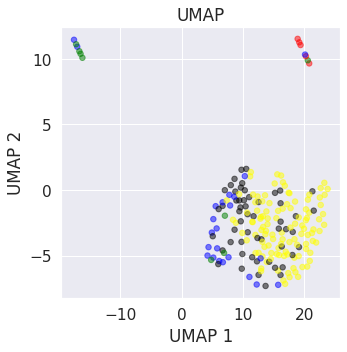

In [ ]:
colors = {0:'red',
          1:'green',
          2:'blue',
          3:'black',
          4:'yellow'}

c = [colors[x] for x in data_eval['label']]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))

ax.scatter(embedding[:, 0], embedding[:, 1],
            c = c, alpha = 0.5, s = 30)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('UMAP')

plt.show()